In [1]:
import numpy as np
from skimage.transform import resize
# from torchinfo import summary
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, RadOncSynthesisDataset, headscanner_training_dataset, headscanner_validation_dataset
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8

import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
from matplotlib.collections import LineCollection
def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

2023-07-17 21:05:51.056755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 21:05:51.365005: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-17 21:05:51.371336: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-17 21:05:51.371366: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
train_path = "/mnt/blackhole-data2/RadOnc_Brain/NonRigid_Training_CBCT"
device = torch.device('cpu')

In [3]:
data = np.load(train_path+'/016.npz')
for key in data.keys():
    print(key)
    if key !='sources':
        print(data[key].shape)


fixed_img
(128, 160, 128)
moving_img
(128, 160, 128)
fixed_warp
(128, 160, 128)
moving_truth
(128, 160, 128)
ventricle_fixed
(128, 160, 128)
ventricle_moving
(128, 160, 128)
affine
(4, 4)
flow
(1, 276, 353, 181, 3)
sources
cbct
(128, 160, 128)
cbct_warp
(128, 160, 128)
structure_fixed
(128, 160, 128, 4)
structure_moving
(128, 160, 128, 4)


In [4]:
mr = data['moving_truth']
gt = data['moving_img']
flow = resize(data['flow'],[1,128,160,128,3])


In [5]:
mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(torch.from_numpy(mr).float().unsqueeze(0).unsqueeze(0), -torch.from_numpy(flow).float().permute(0,4,1,2,3))

/home/myi16/anaconda3/envs/jsr_Y/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Absolute error')

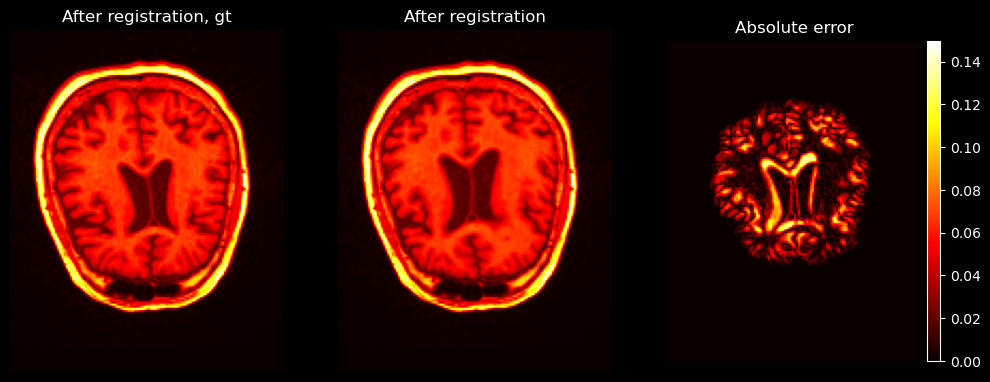

In [6]:
islice = 72
fig, ax = plt.subplots(1,3,figsize=(12,8))
np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0].imshow(gt[:,:,islice].T, cmap='hot')
ax[0].set_title('After registration, gt')

ax[1].imshow(mr_reg[0,0,:,:,islice].T, cmap='hot')
ax[1].set_title('After registration')

img = ax[2].imshow(abs(mr_reg[0,0,:,:,islice]-gt[:,:,islice]).T, cmap='hot')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax, orientation='vertical')
ax[2].set_title('Absolute error')